In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from Deep_Learning.Experimental.Forward_Forward.network import Feedforward
import math

In [95]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
# device = torch.device('cpu')
device

device(type='cuda')

# Build Positive and Negative Datasets

In [96]:
# Will mix two numbers of same class 1/num_classes of the time
class MakeNegativeSample():
    def __init__(self, dataset):
        self.dataset = dataset
        self.n = len(dataset)
    def __call__(self, x, _=None):
        i = torch.randint(0, self.n-1, (x.shape[0],))
        return mix_images(x, self.dataset[i][0])

def mix_images(x1, x2, steps=10):
    device = x1.device
    mask = torch.bernoulli(torch.ones((28,28))*0.5).unsqueeze(0).unsqueeze(0).to(device)
    # blur  with a filter of the form [1/4, 1/2, 1/4] in both horizontal and veritical directions
    filter_h = torch.tensor([[1/4, 1/2, 1/4]]).to(device)
    filter_v = torch.tensor([[1/4], [1/2], [1/4]]).to(device)
    for _ in range(4):
        mask = F.conv2d(mask, filter_h.unsqueeze(0).unsqueeze(0), padding='same')
        mask = F.conv2d(mask, filter_v.unsqueeze(0).unsqueeze(0), padding='same')
    
    # threshold at 0.5
    mask_1 = mask > 0.5
    mask_2 = mask <= 0.5

    out = x1*mask_1 + x2*mask_2
    return out.squeeze(0)


In [97]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=True)
# subset_size = 10000
# raw_dataset = torch.utils.data.Subset(raw_dataset, range(subset_size))

VAL_RATIO = 0.2
n_val = int(len(raw_dataset) * VAL_RATIO)
n_train = len(raw_dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [n_train, n_val])


pos_dataset = PreloadedDataset.from_dataset(train_dataset, None, device)
neg_dataset = PreloadedDataset.from_dataset(pos_dataset, MakeNegativeSample(pos_dataset), device)
val_pos_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
val_neg_dataset = PreloadedDataset.from_dataset(val_pos_dataset, MakeNegativeSample(val_pos_dataset), device)

print(f'Loaded MNIST with {len(pos_dataset)} samples')
# show first samples
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0,i].imshow(pos_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[0,i].set_title(f"Label: {pos_dataset[i][1]}")
    # axs[1,i].imshow(np.squeeze(neg_dataset[i][0].cpu().numpy()), cmap='gray')
    axs[1,i].imshow(neg_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[1,i].set_title(f"Negative Sample")
plt.show()

  0%|          | 0/48000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Train Feedforward Networks Using Forward-Forward

In [ ]:
def train(
    model,
    optimiser,
    pos_dataset,
    neg_dataset,
    val_pos_dataset,
    val_neg_dataset,
    epochs=20,
    batch_size=256,
    mode='minimise',
    neg_coeff=1.0,
    peer_norm_coeff=1.0,
    track_actvs=False,
    actvs=[None for _ in range(4)], # [pos_actv, neg_actv, val_pos_actv, val_neg_actv]
    track_norms=False,
    norms=[None for _ in range(4)], # [pos_norm, neg_norm, val_pos_norm, val_neg_norm]
    track_weights=False,
    weights=None,
    steps=None,
):
    if type(epochs) == int:
        epochs = [epochs for layer in model.layers]
    assert mode in ['minimise', 'maximise'], "Mode must be either 'minimise' or 'maximise'"

    if track_actvs and actvs[0] is None:
        actvs = [[torch.empty((epochs[layer_i], model.layers[layer_i].out_features)) for layer_i in range(len(model.layers))] for _ in range(4)] # actvs[pos/neg/val_pos/val_neg][layer_i][epoch]
    if track_norms and norms[0] is None:
        norms = [[torch.empty((epochs[layer_i],)) for layer_i in range(len(model.layers))] for _ in range(4)] # norms[pos/neg/val_pos/val_neg][layer_i][epoch]
    if track_weights and weights is None:
        weights = [torch.empty((epochs[layer_i], model.layers[layer_i].out_features, model.layers[layer_i].in_features)) for layer_i in range(len(model.layers))] # weights[layer_i][epoch]
    if steps is None:
        steps = [0 for layer in model.layers]

    # Store initial weights
    if track_weights and steps[0] == 0:
        for layer_i in range(len(model.layers)):
            weights[layer_i][0] = model.layers[layer_i].weight.data.clone()

    # Learning Loop
    for layer_i in range(len(model.layers)):
        for ep in range(epochs[layer_i]):

            # Set up dataloaders
            pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size, shuffle=True)
            neg_dataset.apply_transform()
            neg_dataloader = iter(DataLoader(neg_dataset, batch_size=batch_size, shuffle=True))
            val_pos_dataloader = DataLoader(val_pos_dataset, batch_size=batch_size, shuffle=False)
            val_neg_dataset.apply_transform()
            val_neg_dataloader = iter(DataLoader(val_neg_dataset, batch_size=batch_size, shuffle=True))
            loop = tqdm(enumerate(pos_dataloader), total=len(pos_dataloader), leave=False)
            if ep > 0:
                loop.set_description(f"Epoch {ep+1}/{epochs[layer_i]} - Layer {layer_i}/{len(epochs)-1} - Mean Norms (pos/neg): {norms[0][layer_i][ep-1].item():.3f} / {norms[1][layer_i][ep-1].item():.3f}")

            batches_pos_actv_total = torch.zeros((model.layers[layer_i].out_features)).to(device)
            batches_neg_actv_total = torch.zeros((model.layers[layer_i].out_features)).to(device)
            batches_pos_norm_total = torch.zeros((1)).to(device)
            batches_neg_norm_total = torch.zeros((1)).to(device)
            for batch_i, (x, y) in loop:
                model.zero_grad()

                # Positive Pass
                with torch.no_grad():
                    x = x.flatten(start_dim=1)
                    out, x = model(x, layer_i)
                    model.layers[layer_i].weight.grad = (out * torch.sigmoid(out.square().mean() - model.target_actvs[layer_i])).t() @ F.normalize(x, dim=1) * 2/out.numel()
                    # Track activations and norms
                    batches_pos_actv_total += out.detach().sum(dim=0)
                    batches_pos_norm_total += out.detach().norm(dim=1).sum()
            
                # Negative Pass
                with torch.no_grad():
                    x, y = next(neg_dataloader)
                    x = x.flatten(start_dim=1)
                    out, x = model(x, layer_i)
                    model.layers[layer_i].weight.grad += neg_coeff * (out * -torch.sigmoid(-out.square().mean() + model.target_actvs[layer_i])).t() @ F.normalize(x, dim=1) * 2/out.numel()
                    # Track activations and norms
                    batches_neg_actv_total += out.detach().sum(dim=0)
                    batches_neg_norm_total += out.detach().norm(dim=1).sum()

                if mode == 'maximise':
                    model.layers[layer_i].weight.grad *= -1
                optimiser.step()

            # Track epochs
            actvs[0][layer_i][ep] = batches_pos_actv_total / len(pos_dataset)
            actvs[1][layer_i][ep] = batches_neg_actv_total / len(pos_dataset)
            norms[0][layer_i][ep] = batches_pos_norm_total / len(pos_dataset)
            norms[1][layer_i][ep] = batches_neg_norm_total / len(pos_dataset)
            if track_weights:
                weights[layer_i][ep] = model.layers[layer_i].weight.data.clone()
            steps[layer_i] += len(pos_dataset)
            
            # Validation Pass
            batches_val_pos_actv_total = torch.zeros((model.layers[layer_i].out_features)).to(device)
            batches_val_neg_actv_total = torch.zeros((model.layers[layer_i].out_features)).to(device)
            batches_val_pos_norm_total = torch.zeros((1)).to(device)
            batches_val_neg_norm_total = torch.zeros((1)).to(device)
            for batch_i, (x, y) in enumerate(val_pos_dataloader):
                with torch.no_grad():
                    x = x.flatten(start_dim=1)
                    out = model(x, layer_i)[0]
                    # Track activations and norms
                    batches_val_pos_actv_total += out.sum(dim=0)
                    batches_val_pos_norm_total += out.norm(dim=1).sum()
            
                # Negative Pass
                with torch.no_grad():
                    x, y = next(val_neg_dataloader)
                    x = x.flatten(start_dim=1)
                    out = model(x, layer_i)[0]
                    # Track activations and norms
                    batches_val_neg_actv_total += out.sum(dim=0)
                    batches_val_neg_norm_total += out.norm(dim=1).sum()

            # Track mean activations and norms over epochs
            actvs[2][layer_i][ep] = batches_val_pos_actv_total / len(val_pos_dataset)
            actvs[3][layer_i][ep] = batches_val_neg_actv_total / len(val_pos_dataset)
            norms[2][layer_i][ep] = batches_val_pos_norm_total / len(val_pos_dataset)
            norms[3][layer_i][ep] = batches_val_neg_norm_total / len(val_pos_dataset)

    return actvs, norms, weights, steps

In [ ]:
torch.manual_seed(42)

# Hyperparameters
lr = 0.03
reg_coeff = 0.1

# Parameter Initialisation
sizes = [784, 500, 500, 500]
model = Feedforward(sizes, bias=False, dropout=0.1).to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_coeff)
# optimiser = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=reg_coeff)
actvs = [None for _ in range(4)]
norms = [None for _ in range(4)]
weights = None
steps = [0 for _ in model.layers]

In [ ]:
BATCH_SIZE = 512
EPOCHS = 50
actvs, norms, weights, steps = train(
    model,
    optimiser,
    pos_dataset,
    neg_dataset,
    val_pos_dataset,
    val_neg_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    mode='minimise',
    neg_coeff=1.0,
    peer_norm_coeff=0.01,
    track_actvs=True,
    actvs=actvs,
    track_norms=True,
    norms=norms,
    track_weights=True,
    weights=weights,
    steps=steps,
)

KeyboardInterrupt: 

C:\Users\joeag\AppData\Local\Temp\ipykernel_31316\535419277.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = (torch.tensor(norms[0][i]) - torch.tensor(norms[1][i])).abs().numpy()
C:\Users\joeag\AppData\Local\Temp\ipykernel_31316\535419277.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = (torch.tensor(norms[2][i]) - torch.tensor(norms[3][i])).abs().numpy()


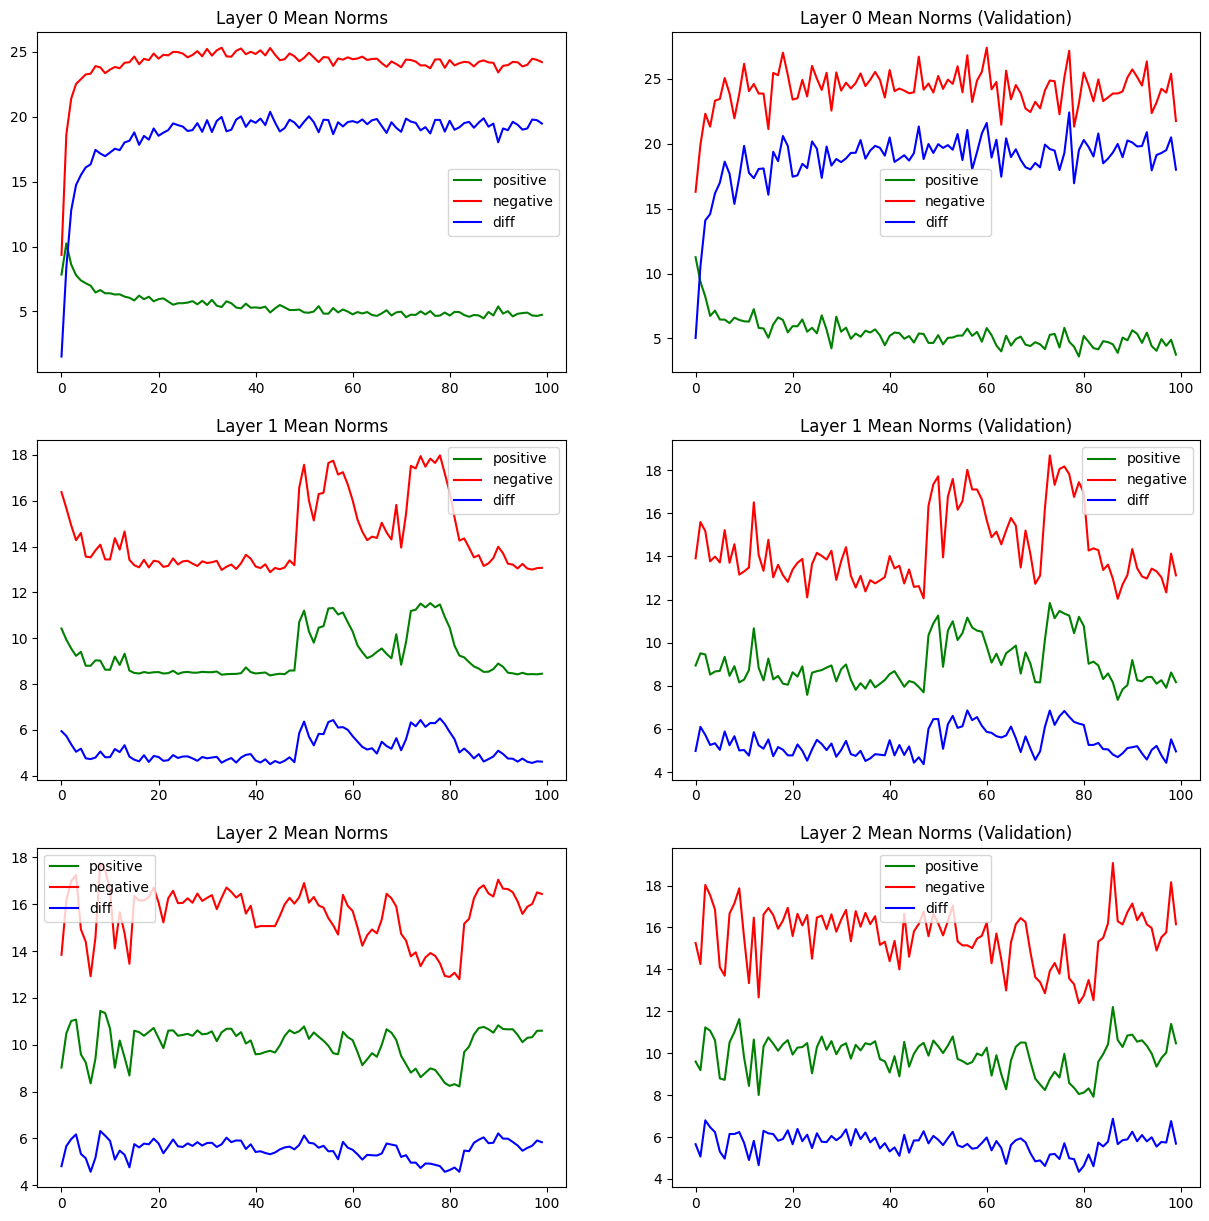

In [ ]:
fig, axs = plt.subplots(len(model.layers), 2, figsize=(15, 15))
for i, layer in enumerate(model.layers):
    diff = (torch.tensor(norms[0][i]) - torch.tensor(norms[1][i])).abs().numpy()
    axs[i, 0].plot(norms[0][i], label="positive", color="green")
    axs[i, 0].plot(norms[1][i], label="negative", color="red")
    axs[i, 0].plot(diff, label="diff", color="blue")
    axs[i, 0].set_title(f"Layer {i} Mean Norms")
    axs[i, 0].legend()

    diff = (torch.tensor(norms[2][i]) - torch.tensor(norms[3][i])).abs().numpy()
    axs[i, 1].plot(norms[2][i], label="positive", color="green")
    axs[i, 1].plot(norms[3][i], label="negative", color="red")
    axs[i, 1].plot(diff, label="diff", color="blue")
    axs[i, 1].set_title(f"Layer {i} Mean Norms (Validation)")
    axs[i, 1].legend()
plt.show()

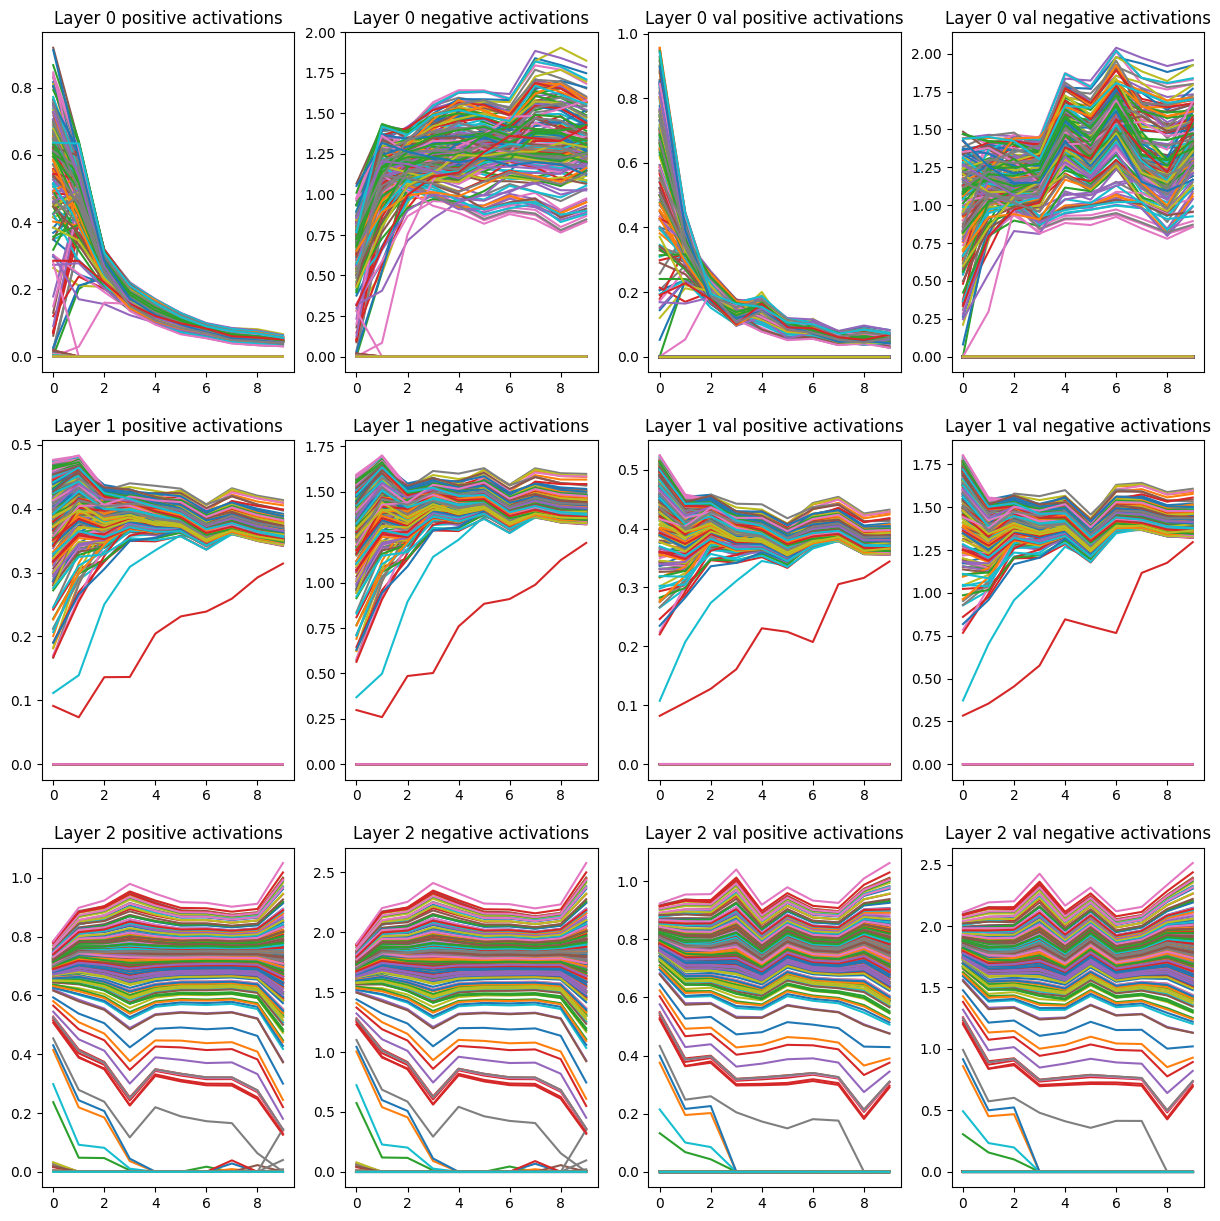

In [ ]:
fig, axs = plt.subplots(len(model.layers), 4, figsize=(15, 15))
for i, layer in enumerate(model.layers):
    axs[i, 0].plot(actvs[0][i])
    axs[i, 0].set_title(f"Layer {i} positive activations")
    axs[i, 1].plot(actvs[1][i])
    axs[i, 1].set_title(f"Layer {i} negative activations")

    axs[i, 2].plot(actvs[2][i])
    axs[i, 2].set_title(f"Layer {i} val positive activations")
    axs[i, 3].plot(actvs[3][i])
    axs[i, 3].set_title(f"Layer {i} val negative activations")
plt.show()

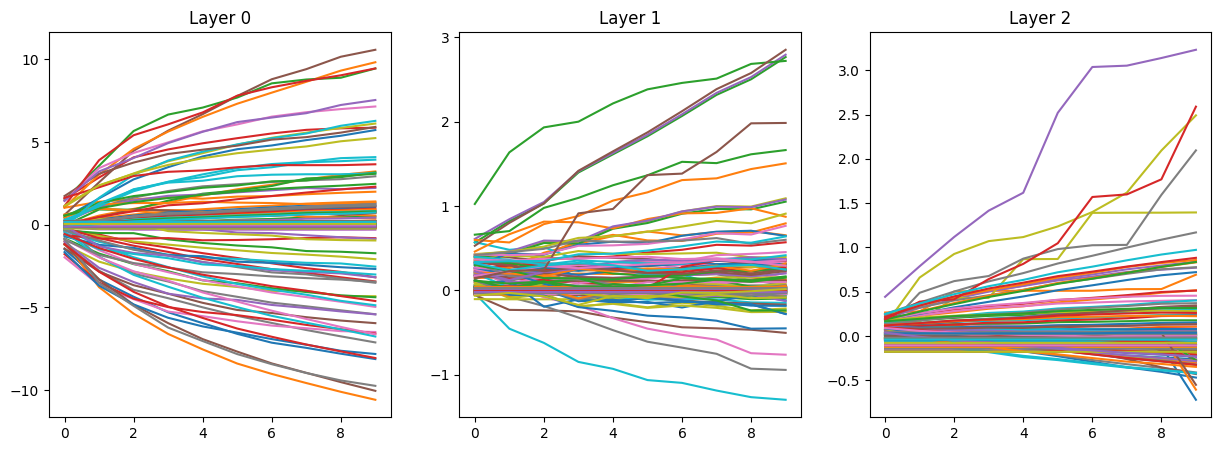

In [ ]:
k = 200
weights = [weights[i].flatten(start_dim=1) for i in range(len(weights))]
perms = [torch.randperm(weights[i].shape[1]) for i in range(len(weights))]
idxs = [perms[i][:k] for i in range(len(weights))]
weights = [weights[i][:, idxs[i]] for i in range(len(weights))]
fig, axs = plt.subplots(1, len(model.layers), figsize=(15, 5))
for i in range(len(model.layers)):
    axs[i].plot(weights[i])
    axs[i].set_title(f'Layer {i}')
plt.show()

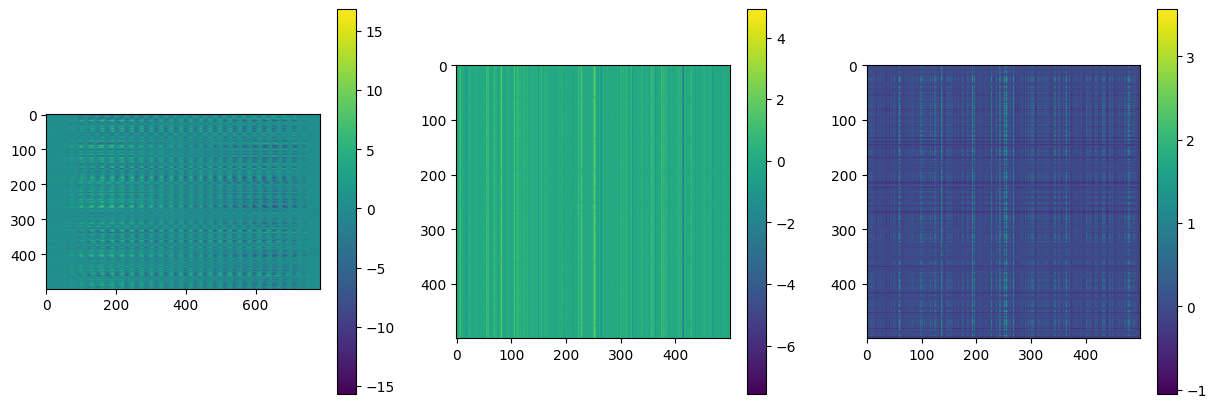

In [ ]:
# Plot weights
plt.figure(figsize=(15, 5))
for i, l in enumerate(model.layers):
    plt.subplot(1, len(model.layers), i+1)
    plt.imshow(l.weight.data.cpu().numpy())
    plt.colorbar()
plt.show()

# Train Classifier on network activations

In [ ]:
def train_classifier(
    model,
    classifier, 
    train_dataset, 
    val_dataset, 
    epochs, 
    batch_size,
    optimiser, 
    criterion, 
    train_loss=[],
    val_loss=[],
    val_acc=[],
    steps = [],
):
    model.eval()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        classifier.train()
        running_loss = 0.0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        if epoch > 0:
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(train_loss=train_loss[-1], val_loss=val_loss[-1], val_acc=val_acc[-1])
        for i, data in loop:
            x, y = data
            x = x.flatten(start_dim=1)
            with torch.no_grad():
                x = model(x)
                x = x[1:]
                x = [F.normalize(x_i, dim=1) for x_i in x]
                x = torch.cat(x, dim=1)

            optimiser.zero_grad()
            y_pred = classifier(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimiser.step()

            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))
        if len(steps) > 0:
            steps.append(steps[-1] + len(train_dataset))
        else:
            steps.append(len(train_dataset))

        classifier.eval()
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(val_loader):
            x, y = data
            x = x.flatten(start_dim=1)
            with torch.no_grad():
                x = model(x)
                x = x[1:]
                x = [F.normalize(x_i, dim=1) for x_i in x]
                x = torch.cat(x, dim=1)

            y_pred = classifier(x)
            loss = criterion(y_pred, y)
            running_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == y).sum().item()
        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / len(val_dataset))

    return train_loss, val_loss, val_acc, steps


In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

in_size = [layer.out_features for layer in model.layers]
in_size = sum(in_size[1:])
print(f"Input size: {in_size}")
classifier = Classifier(in_size, 100, 10).to(device)
optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loss = []
val_loss = []
val_acc = []
steps = []   

Input size: 1000


In [ ]:
EPOCHS = 30
BATCH_SIZE = 256

train_loss, val_loss, val_acc, steps = train_classifier(model, classifier, pos_dataset, val_pos_dataset, EPOCHS, BATCH_SIZE, optimiser, criterion, train_loss, val_loss, val_acc, steps)

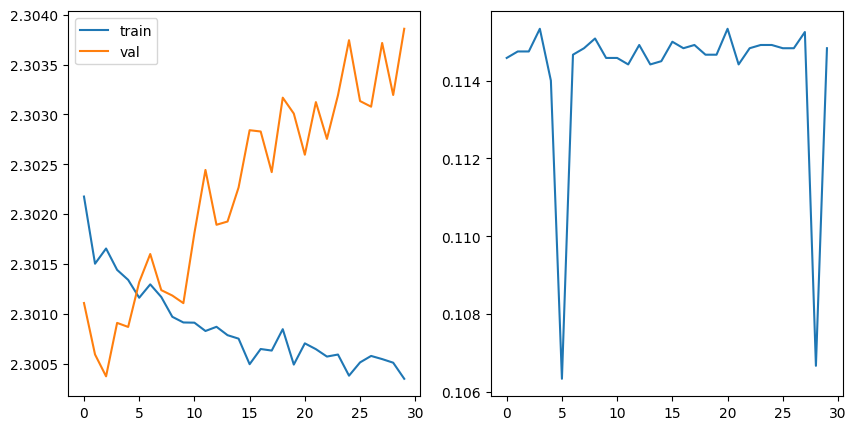

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_loss, label='train')
axs[0].plot(val_loss, label='val')
axs[0].legend()

axs[1].plot(val_acc)

plt.show()
